In [58]:
import salem as sa
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyproj import Proj
import numpy as np
import pandas as pd

In [59]:
data_base_folder = Path('/home/ben/data/GAR/')
project = 'rc_trop_ls_vert43'

In [60]:
color_map = LinearSegmentedColormap.from_list(
    "mycmap",
    ["white", "steelblue", "c", "khaki", "orange", "orangered", "r", "darkred"],
)

def plot_map(ax, ds, model, cmap, scalebar=False):
    smap = ds.salem.get_map(data=model, cmap=cmap, vmin=0, vmax=1020)
    x, y = smap.grid.transform(lons, lats)
    smap.set_shapefile(countries=False)
    smap.set_lonlat_contours(xinterval=1)
    if scalebar:
        smap.set_scale_bar(location=(0.85, 0.08))
    smap.visualize(addcbar=False)
    return smap

In [61]:
def remove_nonalphanumerics(string: str) -> str:
    return "".join(ch for ch in string if ch.isalnum())

def open_dataset(file, ):
    data_base_folder = Path('/home/ben/data/GAR/')
    ds = xr.open_dataset(
        data_base_folder/file,
        decode_cf=False
    )
    projection = {
        "lat_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[3]),
        "lon_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[4]),
        "x_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[5]),
        "y_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[5]),
        "ellps": remove_nonalphanumerics(ds.attrs["PROJ_ENVI_STRING"].split(",")[7]),
        "name": remove_nonalphanumerics(
            str(ds.attrs["PROJ_ENVI_STRING"].split(",")[8])
        ),
    }
    # pyproj_srs='+proj=merc +lat_0=2 +lon_0=-89.5 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
    proj = "merc" if projection["name"].lower() == "wrfmercator" else "lcc"
    pyproj_srs = (
        f"+proj={proj} +lat_0={str(projection['lat_0'])} +lon_0={str(projection['lon_0'])} +k=1 "
        f"+x_0={str(projection['x_0'])} +y_0={str(projection['y_0'])} +ellps={projection['ellps']} "
        f"+datum={projection['ellps']} +units=m +no_defs"
    )

    split = file.split('/')[-1].split('_')
    var = split[-2]
    if var == 'lu':
        var = split[-2] + '_' + split[-1].split('.')[0]
    ds[var].attrs['pyproj_srs'] = pyproj_srs
    return ds

grid = sa.mercator_grid(center_ll=(-90, 0), extent=(100000, 100000))
oceans = sa.read_shapefile(sa.get_demo_file('ne_50m_ocean.shp'),
                              cached=True)
grid

<salem.Grid>
  proj: +datum=WGS84 +k=0.9996 +lat_0=0 +lon_0=-90 +no_defs+proj=tmerc +units=m +x_0=0 +y_0=0
  pixel_ref: corner
  origin: lower-left
  (nx, ny): (600, 600)
  (dx, dy): (166.66666666666666, 166.66666666666666)
  (x0, y0): (-50000.0, -50000.0)

In [62]:
# kain_fritsch = open_dataset(
#     'rc_trop_KF/products/d02/d/2d/rc_trop_KF_d02km_d_2d_prcp_2017.nc',
# )
# grell_3d = open_dataset(
#     'rc_trop_G3D/products/d02km/d/2d/rc_trop_G3D_d02km_d_2d_prcp_2017.nc',
# )
# mod_kain_fritsch = open_dataset(
#     'rc_trop_mKF/rc_trop_mKF_d02km_d_2d_prcp_2017.nc',
# )
trop = open_dataset(
    'rc_trop_l/rc_trop_l_d02km_d_2d_prcp_2017.nc',
)
thompson = open_dataset(
    'rc_trop_TG/rc_trop_TG_d02km_d_2d_prcp_2017.nc'
)

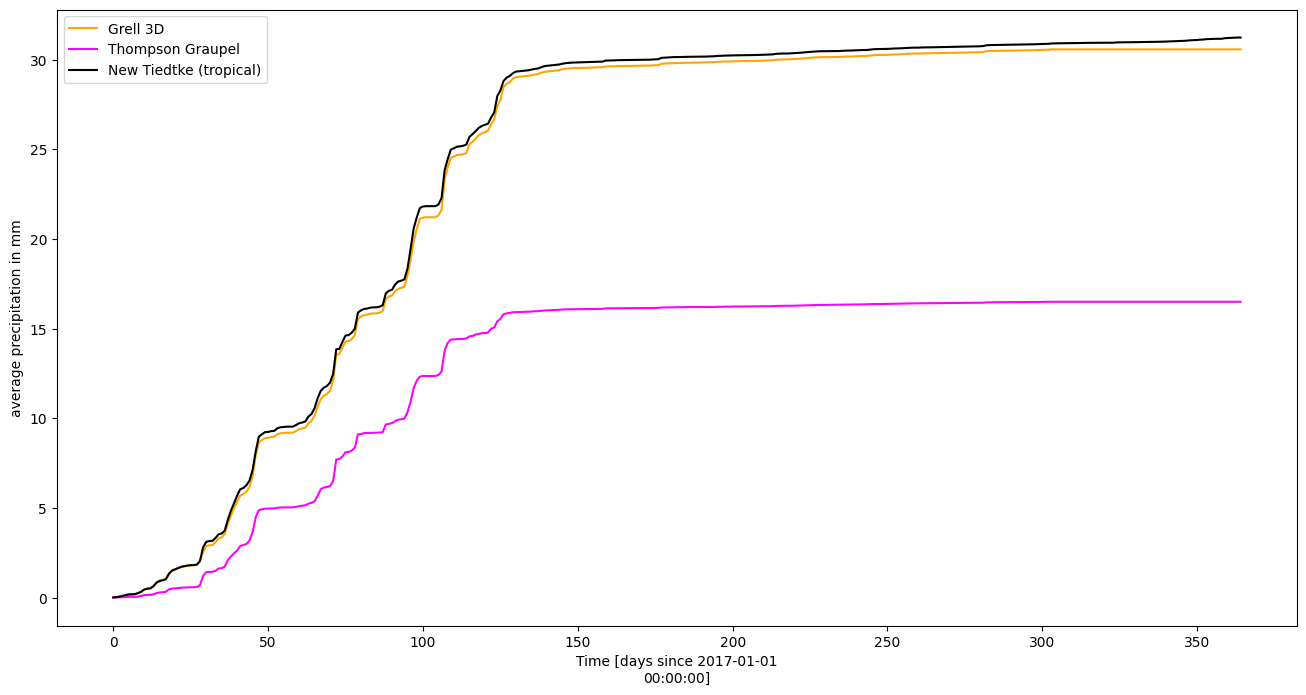

In [63]:
fig, ax = plt.subplots(figsize=(16,8))
# mask_kain_fritsch = kain_fritsch.prcp.salem.roi(shape=oceans, all_touched=True)
# mask_kain_fritsch.mean(axis=(1,2)).cumsum().plot(ax=ax, label="Kain-Fritsch", color='b')

mask_grell_3d = grell_3d.prcp.salem.roi(shape=oceans, all_touched=True)
mask_grell_3d.mean(axis=(1,2)).cumsum().plot(ax=ax, label="Grell 3D", color='orange')

# mask_mod_kain_fritsch = mod_kain_fritsch.prcp.salem.roi(shape=oceans, all_touched=True)
# mask_mod_kain_fritsch.mean(axis=(1,2)).cumsum().plot(ax=ax, label="modified Kain-Fritsch", color='g')

mask_thompson = thompson.prcp.salem.roi(shape=oceans, all_touched=True)
mask_thompson.mean(axis=(1,2)).cumsum().plot(ax=ax, label="Thompson Graupel", color='magenta')

mask_trop = trop.prcp.salem.roi(shape=oceans, all_touched=True)
mask_trop.mean(axis=(1,2)).cumsum().plot(ax=ax, label="New Tiedtke (tropical)", color='k')
#
plt.ylabel('average precipitation in mm')
ax.legend()
# plt.savefig("domain_sizes_prcp_land.png")
plt.show()